Using London Enery data from Kaggle to explore XGBoost timeseries forecasting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('london_energy.csv')

In [2]:
df.head()

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [3]:
df.describe()

,KWH
count,3.510433e+06
mean,1.013001e+01
std,9.134486e+00
min,0.000000e+00
25%,4.685000e+00
50%,7.819000e+00
75%,1.257600e+01
max,3.325560e+02


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   LCLid   object 
 1   Date    object 
 2   KWH     float64
dtypes: float64(1), object(2)
memory usage: 80.3+ MB


In [5]:
df.isna().sum()

LCLid    0
Date     0
KWH      0
dtype: int64

In [6]:
df.groupby('Date')['KWH'].mean()

Date
2011-11-23     6.952692
2011-11-24     8.536480
2011-11-25     9.499781
2011-11-26    10.267707
2011-11-27    10.850805
                ...    
2014-02-24    10.411403
2014-02-25    10.294997
2014-02-26    10.202945
2014-02-27    10.356350
2014-02-28     0.417993
Name: KWH, Length: 829, dtype: float64

In [7]:
import pandas as pd
df_avg_consumption = df.groupby('Date')['KWH'].mean()
df_avg_consumption = pd.DataFrame(df_avg_consumption).reset_index()
df_avg_consumption = df_avg_consumption.rename(columns={'Date': 'date',  'KWH': 'consumption'})
df_avg_consumption

,date,consumption
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805
...,...,...
824,2014-02-24,10.411403
825,2014-02-25,10.294997
826,2014-02-26,10.202945
827,2014-02-27,10.356350


In [8]:
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])

print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


<Axes: xlabel='date'>

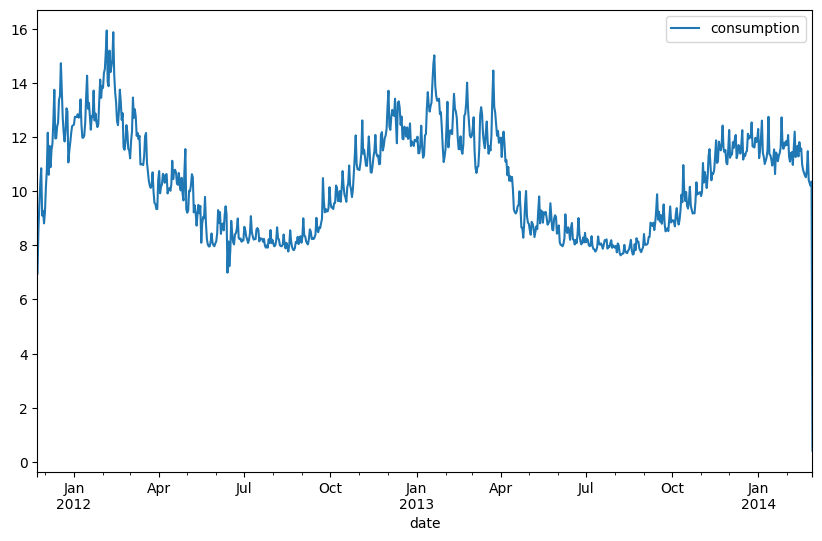

In [9]:
df_avg_consumption.plot(x='date', y='consumption', figsize=(10, 6))

<Axes: xlabel='date'>

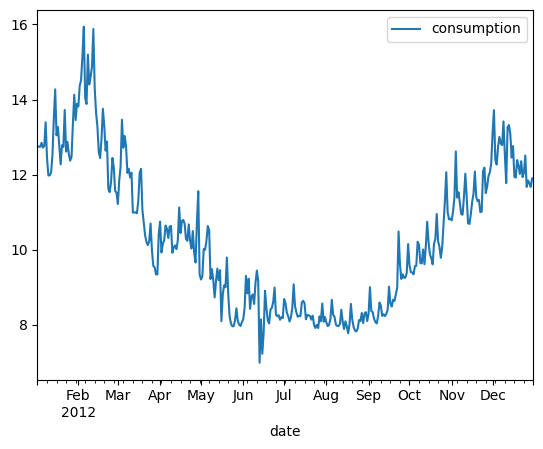

In [10]:
#taking a slice of the data
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")


In [11]:
# create features manually 
df_avg_consumption["day_of_week"] = df_avg_consumption['date'].dt.day_of_week
df_avg_consumption["day_of_year"] = df_avg_consumption['date'].dt.day_of_year
df_avg_consumption["month"] = df_avg_consumption['date'].dt.month
df_avg_consumption["quarter"] = df_avg_consumption['date'].dt.quarter
df_avg_consumption["year"] = df_avg_consumption['date'].dt.year



df_avg_consumption

,date,consumption,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,2,327,11,4,2011
1,2011-11-24,8.536480,3,328,11,4,2011
2,2011-11-25,9.499781,4,329,11,4,2011
3,2011-11-26,10.267707,5,330,11,4,2011
4,2011-11-27,10.850805,6,331,11,4,2011
...,...,...,...,...,...,...,...
824,2014-02-24,10.411403,0,55,2,1,2014
825,2014-02-25,10.294997,1,56,2,1,2014
826,2014-02-26,10.202945,2,57,2,1,2014
827,2014-02-27,10.356350,3,58,2,1,2014


In [12]:
train_temp = df_avg_consumption['date'] < '2013-07-28'
training_data = df_avg_consumption.loc[train_temp]
training_data.shape

(613, 7)

In [13]:
test_temp = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[test_temp]
print(testing_data.shape)

(216, 7)


<Axes: xlabel='date'>

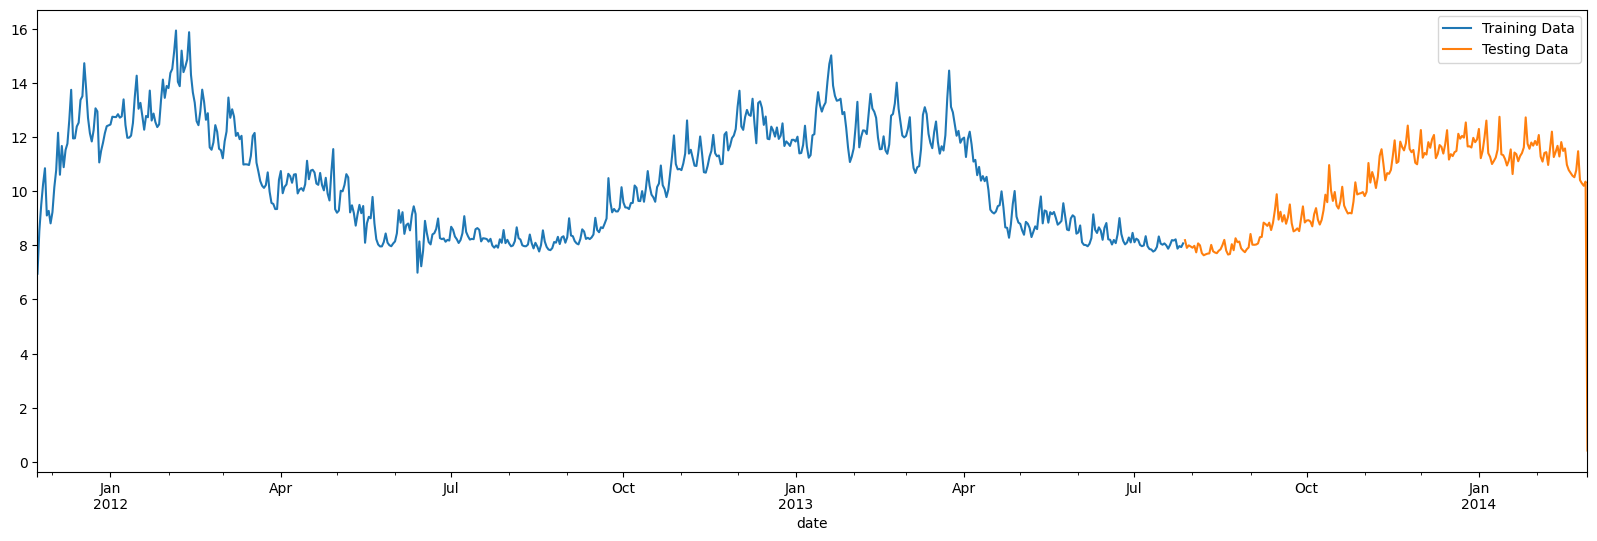

In [14]:
# need to plot train and test data togeher 

import matplotlib.pyplot as plt
figure, ax = plt.subplots(figsize=(20, 6))
training_data.plot(ax=ax, x='date', y='consumption', label='Training Data')
testing_data.plot(ax=ax, x='date', y='consumption', label='Testing Data')


In [15]:
training_data = training_data.drop('date', axis=1)
test_dates = testing_data['date']
testing_data = testing_data.drop('date', axis=1)

In [16]:
training_data.columns

Index(['consumption', 'day_of_week', 'day_of_year', 'month', 'quarter',
       'year'],
      dtype='object')

In [17]:
X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_train = training_data["consumption"]

X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year"]]
y_test = testing_data["consumption"]

In [19]:
#time to use xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [20]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
cv_split

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100)

In [21]:
model = XGBRegressor()

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

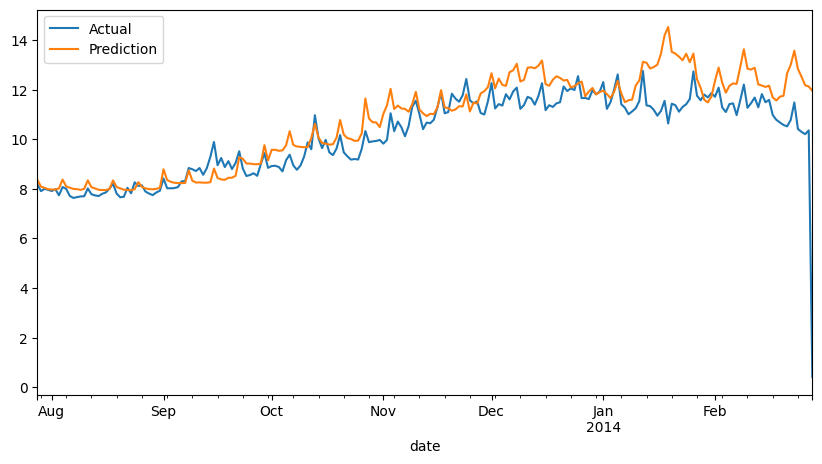

MAE: 0.7241435626141807
MSE: 1.428444901207855
MAPE: 0.19172610314901012


In [24]:
prediction = grid_search.predict(X_test)
plot_predictions(test_dates, y_test, prediction)
evaluate_model(y_test, prediction)